device: cuda


/home/linhht419/Downloads/enter/envs/pettingzoo/lib/python3.9/site-packages/pettingzoo/utils/conversions.py:132: UserWarning: The base environment `sagin_v1` does not have a `render_mode` defined.
  warnings.warn(


Training episode 0
Episodic Return: -16.066667556762695
Episode Length: 99

Value Loss: 35.39197540283203
Policy Loss: 6.692965030670166
Old Approx KL: 0.0035530461464077234
Approx KL: 6.304847192950547e-05
Clip Fraction: 0.029166666666666667
Explained Variance: 5.3942203521728516e-05

-------------------------------------------

Training episode 1
Episodic Return: 13.800000190734863
Episode Length: 99

Value Loss: 24.39243507385254
Policy Loss: -6.345481872558594
Old Approx KL: 0.00097364850807935
Approx KL: 0.00039327144622802734
Clip Fraction: 0.08067129651705424
Explained Variance: 1.1265277862548828e-05

-------------------------------------------

Training episode 2
Episodic Return: -9.0
Episode Length: 99

Value Loss: 41.51397705078125
Policy Loss: 8.401060104370117
Old Approx KL: 0.010634488426148891
Approx KL: 0.0005095601081848145
Clip Fraction: 0.06041666666666667
Explained Variance: 4.482269287109375e-05

-------------------------------------------

Training episode 3
Episo

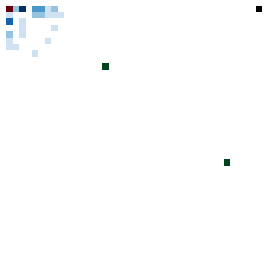

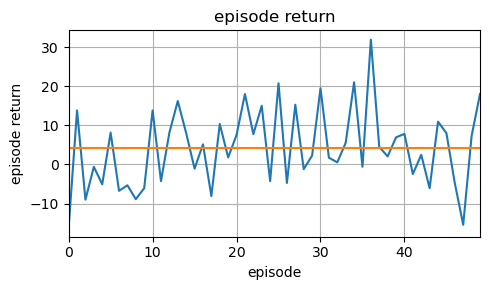

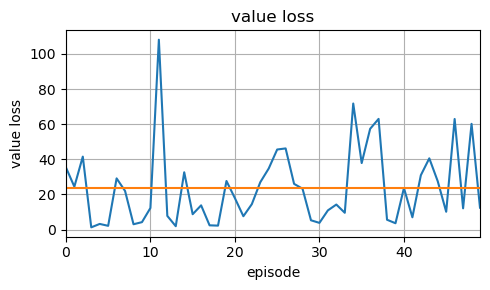

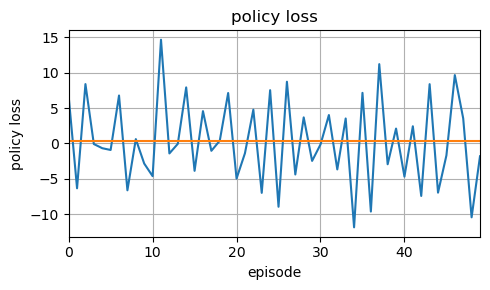

In [2]:
"""Basic code which shows what it's like to run PPO on the Pistonball env using
the parallel API, this code is inspired by CleanRL.

This code is exceedingly basic, with no logging or weights saving.
The intention was for users to have a (relatively clean) ~200 line file to refer
to when they want to design their own learning algorithm.

Author: Jet (https://github.com/jjshoots)
"""

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from supersuit import color_reduction_v0, frame_stack_v1, resize_v1
from torch.distributions.categorical import Categorical
from envs.sagin_v1 import *
from envs.utils import *

class Agent_v0(nn.Module):
    def __init__(self, num_actions):
        super().__init__()

        self.network = nn.Sequential(
            self._layer_init(nn.Conv2d(4, 64, 3, padding=1)),
            nn.MaxPool2d(2),
            nn.ReLU(),
            self._layer_init(nn.Conv2d(64, 64, 3, padding=1)),
            nn.MaxPool2d(2),
            nn.ReLU(),
            self._layer_init(nn.Conv2d(64, 64, 3, padding=1)),
            nn.MaxPool2d(2),
            nn.ReLU(),
            self._layer_init(nn.Conv2d(64, 128, 3, padding=1)),
            nn.MaxPool2d(2),
            nn.ReLU(),
            self._layer_init(nn.Conv2d(128, 128, 3, padding=1)),
            nn.MaxPool2d(2),
            nn.ReLU(),
            self._layer_init(nn.Conv2d(128, 128, 3, padding=1)),
            nn.MaxPool2d(2),
            nn.ReLU(),
            self._layer_init(nn.Conv2d(128, 256, 3, padding=1)),
            nn.MaxPool2d(2),
            nn.ReLU(),
            self._layer_init(nn.Conv2d(256, 256, 3, padding=1)),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Flatten(),
            self._layer_init(nn.Linear(256 * 1 * 1, 512)),
            nn.ReLU(),
        )
        self.actor = self._layer_init(nn.Linear(512, num_actions), std=0.01)
        self.critic = self._layer_init(nn.Linear(512, 1))

    def _layer_init(self, layer, std=np.sqrt(2), bias_const=0.0):
        torch.nn.init.orthogonal_(layer.weight, std)
        torch.nn.init.constant_(layer.bias, bias_const)
        return layer

    def get_value(self, x):
        return self.critic(self.network(x / 255.0))

    def get_action_and_value(self, x, action=None):
        hidden = self.network(x / 255.0)
        logits = self.actor(hidden)
        probs = Categorical(logits=logits)
        if action is None:
            action = probs.sample()
        return action, probs.log_prob(action), probs.entropy(), self.critic(hidden)


class Agent(nn.Module):
    def __init__(self, num_actions):
        super().__init__()

        self.network = nn.Sequential(
            self._layer_init(nn.Conv2d(4, 32, 3, padding=1)),
            nn.AvgPool2d(2),
            nn.ReLU(),
            self._layer_init(nn.Conv2d(32, 32, 3, padding=1)),
            nn.AvgPool2d(2),
            nn.ReLU(),
            self._layer_init(nn.Conv2d(32, 32, 3, padding=1)),
            nn.AvgPool2d(2),
            nn.ReLU(),
            self._layer_init(nn.Conv2d(32, 64, 3, padding=1)),
            nn.AvgPool2d(2),
            nn.ReLU(),
            self._layer_init(nn.Conv2d(64, 64, 3, padding=1)),
            nn.AvgPool2d(2),
            nn.ReLU(),
            self._layer_init(nn.Conv2d(64, 64, 3, padding=1)),
            nn.AvgPool2d(2),
            nn.ReLU(),
            self._layer_init(nn.Conv2d(64, 128, 3, padding=1)),
            nn.AvgPool2d(2),
            nn.ReLU(),
            self._layer_init(nn.Conv2d(128, 128, 3, padding=1)),
            nn.AvgPool2d(2),
            nn.ReLU(),
            nn.Flatten(),
            self._layer_init(nn.Linear(128 * 1 * 1, 512)),
            nn.ReLU(),
        )
        self.actor = self._layer_init(nn.Linear(512, num_actions), std=0.01)
        self.critic = self._layer_init(nn.Linear(512, 1))

    def _layer_init(self, layer, std=np.sqrt(2), bias_const=0.0):
        torch.nn.init.orthogonal_(layer.weight, std)
        torch.nn.init.constant_(layer.bias, bias_const)
        return layer

    def get_value(self, x):
        return self.critic(self.network(x / 255.0))

    def get_action_and_value(self, x, action=None):
        hidden = self.network(x / 255.0)
        logits = self.actor(hidden)
        probs = Categorical(logits=logits)
        if action is None:
            action = probs.sample()
        return action, probs.log_prob(action), probs.entropy(), self.critic(hidden)


def batchify_obs(obs, device):
    """Converts PZ style observations to batch of torch arrays."""
    # convert to list of np arrays
    obs = np.stack([obs[a] for a in obs], axis=0)
    # transpose to be (batch, channel, height, width)
    obs = obs.transpose(0, -1, 1, 2)
    # convert to torch
    obs = torch.tensor(obs).to(device)

    return obs


def batchify(x, device):
    """Converts PZ style returns to batch of torch arrays."""
    # convert to list of np arrays
    x = np.stack([x[a] for a in x], axis=0)
    # convert to torch
    x = torch.tensor(x).to(device)

    return x


def unbatchify(x, env):
    """Converts np array to PZ style arguments."""
    x = x.cpu().numpy()
    x = {a: x[i] for i, a in enumerate(env.possible_agents)}

    return x


if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f'device: {device}')

    """ALGO PARAMS"""
    ent_coef = 0.1
    vf_coef = 0.1
    clip_coef = 0.1
    gamma = 0.99
    batch_size = 32
    # stack_size = 1
    # frame_size = (64, 64)
    max_cycles = 100
    total_episodes = 50
    lrate = 1e-3
    n_reuse = 3             # no. of reuse times for the experiment of an episode

    """ ENV SETUP """
    env = parallel_env(seed=42, max_cycles=max_cycles)
    # env = color_reduction_v0(env)
    # env = resize_v1(env, frame_size[0], frame_size[1])
    # env = frame_stack_v1(env, stack_size=stack_size)
    num_agents = len(env.possible_agents)
    num_actions = env.action_space(env.possible_agents[0]).n
    observation_size = env.observation_space(env.possible_agents[0]).shape

    """ LEARNER SETUP """
    agent = Agent(num_actions=num_actions).to(device)
    optimizer = optim.Adam(agent.parameters(), lr=lrate, eps=lrate / 100)

    """ ALGO LOGIC: EPISODE STORAGE"""
    end_step = 0
    total_episodic_return = 0
    # rb_obs = torch.zeros((max_cycles, num_agents, stack_size, *frame_size)).to(device)
    rb_obs = torch.zeros((max_cycles, num_agents, *observation_size[::-1])).to(device)
    rb_actions = torch.zeros((max_cycles, num_agents)).to(device)
    rb_logprobs = torch.zeros((max_cycles, num_agents)).to(device)
    rb_rewards = torch.zeros((max_cycles, num_agents)).to(device)
    rb_terms = torch.zeros((max_cycles, num_agents)).to(device)
    rb_values = torch.zeros((max_cycles, num_agents)).to(device)

    log_ep_return = np.zeros(total_episodes); log_ep_return[:] = np.nan
    log_value_loss = np.zeros(total_episodes); log_value_loss[:] = np.nan
    log_policy_loss = np.zeros(total_episodes); log_policy_loss[:] = np.nan

    """ TRAINING LOGIC """
    # train for n number of episodes
    for episode in range(total_episodes):
        # collect an episode
        with torch.no_grad():
            # collect observations and convert to batch of torch tensors
            next_obs, info = env.reset(seed=None)
            # reset the episodic return
            total_episodic_return = 0

            # each episode has num_steps
            end_step = max_cycles - 1       # if not terminated early
            for step in range(0, max_cycles):
                # rollover the observation
                obs = batchify_obs(next_obs, device)

                # get action from the agent
                actions, logprobs, _, values = agent.get_action_and_value(obs)

                # execute the environment and log data
                next_obs, rewards, terms, truncs, infos = env.step(
                    unbatchify(actions, env)
                )

                # add to episode storage
                rb_obs[step] = obs
                rb_rewards[step] = batchify(rewards, device)
                rb_terms[step] = batchify(terms, device)
                rb_actions[step] = actions
                rb_logprobs[step] = logprobs
                rb_values[step] = values.flatten()

                # compute episodic return
                total_episodic_return += rb_rewards[step].cpu().numpy()

                # if we reach termination or truncation, end
                if any([terms[a] for a in terms]) or any([truncs[a] for a in truncs]):
                    end_step = step     # terminated early
                    break

        # bootstrap value if not done
        with torch.no_grad():
            rb_advantages = torch.zeros_like(rb_rewards).to(device)
            for t in reversed(range(end_step)):
                delta = (
                    rb_rewards[t]
                    + gamma * rb_values[t + 1] * rb_terms[t + 1]
                    - rb_values[t]
                )
                rb_advantages[t] = delta + gamma * gamma * rb_advantages[t + 1]
            rb_returns = rb_advantages + rb_values

        # convert our episodes to batch of individual transitions
        b_obs = torch.flatten(rb_obs[:end_step], start_dim=0, end_dim=1)
        b_logprobs = torch.flatten(rb_logprobs[:end_step], start_dim=0, end_dim=1)
        b_actions = torch.flatten(rb_actions[:end_step], start_dim=0, end_dim=1)
        b_returns = torch.flatten(rb_returns[:end_step], start_dim=0, end_dim=1)
        b_values = torch.flatten(rb_values[:end_step], start_dim=0, end_dim=1)
        b_advantages = torch.flatten(rb_advantages[:end_step], start_dim=0, end_dim=1)

        # Optimizing the policy and value network
        b_index = np.arange(len(b_obs))
        clip_fracs = []
        for repeat in range(n_reuse):
            # shuffle the indices we use to access the data
            np.random.shuffle(b_index)
            for start in range(0, len(b_obs), batch_size):
                # select the indices we want to train on
                end = start + batch_size
                batch_index = b_index[start:end]

                _, newlogprob, entropy, value = agent.get_action_and_value(
                    b_obs[batch_index], b_actions.long()[batch_index]
                )
                logratio = newlogprob - b_logprobs[batch_index]
                ratio = logratio.exp()

                # clip fraction
                with torch.no_grad():
                    # calculate approx_kl http://joschu.net/blog/kl-approx.html
                    old_approx_kl = (-logratio).mean()
                    approx_kl = ((ratio - 1) - logratio).mean()
                    clip_fracs += [
                        ((ratio - 1.0).abs() > clip_coef).float().mean().item()
                    ]

                # normalize advantaegs
                advantages = b_advantages[batch_index]
                advantages = (advantages - advantages.mean()) / (
                    advantages.std() + 1e-8
                )

                # Policy loss
                pg_loss1 = -b_advantages[batch_index] * ratio
                pg_loss2 = -b_advantages[batch_index] * torch.clamp(
                    ratio, 1 - clip_coef, 1 + clip_coef
                )
                pg_loss = torch.max(pg_loss1, pg_loss2).mean()

                # Value loss
                value = value.flatten()
                v_loss_unclipped = (value - b_returns[batch_index]) ** 2
                v_clipped = b_values[batch_index] + torch.clamp(
                    value - b_values[batch_index],
                    -clip_coef,
                    clip_coef,
                )
                v_loss_clipped = (v_clipped - b_returns[batch_index]) ** 2
                v_loss_max = torch.max(v_loss_unclipped, v_loss_clipped)
                v_loss = 0.5 * v_loss_max.mean()

                entropy_loss = entropy.mean()
                loss = pg_loss - ent_coef * entropy_loss + v_loss * vf_coef

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        y_pred, y_true = b_values.cpu().numpy(), b_returns.cpu().numpy()
        var_y = np.var(y_true)
        explained_var = np.nan if var_y == 0 else 1 - np.var(y_true - y_pred) / var_y

        log_ep_return[episode] = np.mean(total_episodic_return)
        log_value_loss[episode] = v_loss.item()
        log_policy_loss[episode] = pg_loss.item()

        print(f"Training episode {episode}")
        print(f"Episodic Return: {log_ep_return[episode]}")
        print(f"Episode Length: {end_step}")
        print("")
        print(f"Value Loss: {log_value_loss[episode]}")
        print(f"Policy Loss: {log_policy_loss[episode]}")
        print(f"Old Approx KL: {old_approx_kl.item()}")
        print(f"Approx KL: {approx_kl.item()}")
        print(f"Clip Fraction: {np.mean(clip_fracs)}")
        print(f"Explained Variance: {explained_var.item()}")
        print("\n-------------------------------------------\n")

    """ PLOTTING """
    import matplotlib.pyplot as plt
    import pandas as pd

    window = 3
    df = pd.DataFrame({
            'episode return': log_ep_return,
            'value loss': log_value_loss,
            'policy loss': log_policy_loss
    })

    for col in df.columns:
            fig, ax = plt.subplots(figsize=(5,3))
            ax.plot(df[col])
            ax.plot(df[col].rolling(window=100, min_periods=1, center=True).mean())
            ax.set_title(col)
            ax.set_xlabel('episode')
            ax.set_ylabel(col)
            ax.margins(x=0)
            ax.grid(True)
            fig.tight_layout()
            plt.savefig(os.path.join(os.getcwd(), "tmp", f"{col}.png"))
            plt.show()
            plt.close()


/home/linhht419/Downloads/enter/envs/pettingzoo/lib/python3.9/site-packages/pettingzoo/utils/conversions.py:132: UserWarning: The base environment `sagin_v1` does not have a `render_mode` defined.
  warnings.warn(
/tmp/ipykernel_97908/1490803888.py:53: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


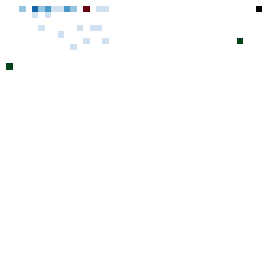

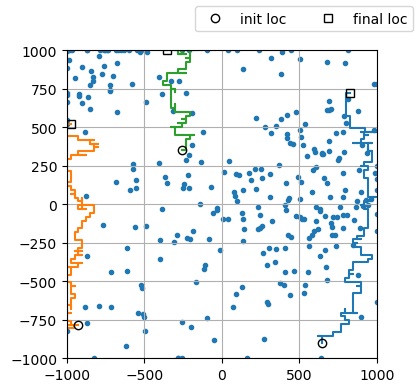

In [3]:
""" RENDER THE POLICY """
env = parallel_env(seed=42, max_cycles=200)
# env = color_reduction_v0(env)
# env = resize_v1(env, 64, 64)
# env = frame_stack_v1(env, stack_size=4)

agent.eval()

n_episodes = 1
# for logging
log_uav_locs = []

with torch.no_grad():
    # render 5 episodes out
    for episode in range(n_episodes):
        obs, infos = env.reset(seed=None)
        obs = batchify_obs(obs, device)
        terms = [False]
        truncs = [False]
        while not any(terms) and not any(truncs):
            # loggging
            log_uav_locs.append(env.unwrapped.locs['uav'].copy())

            actions, logprobs, _, values = agent.get_action_and_value(obs)
            obs, rewards, terms, truncs, infos = env.step(unbatchify(actions, env))
            obs = batchify_obs(obs, device)
            terms = [terms[a] for a in terms]
            truncs = [truncs[a] for a in truncs]

""" PLOTTING """
user_locs = env.unwrapped.locs['user']
log_uav_locs = np.array(log_uav_locs)
n_uavs = log_uav_locs.shape[-1]
user_locs = env.unwrapped.locs['user']

fig = plt.figure(figsize=(4,4))
ax = fig.gca()
ax.set_xlim(-1000, 1000)
ax.set_ylim(-1000, 1000)
ax.grid(True)
for uav_id in range(n_uavs):
    loc_uav = log_uav_locs[:, :, uav_id].transpose()
    ax.plot(loc_uav[0], loc_uav[1])
    if uav_id == n_uavs - 1:
        l_init, l_final = "init loc", "final loc"
    else:
        l_init, l_final = "", ""
    ax.plot(loc_uav[0][0], loc_uav[1][0], 'ok', markerfacecolor="None", label=l_init)
    ax.plot(loc_uav[0][-1], loc_uav[1][-1], 'sk', markerfacecolor="None", label=l_final)
ax.scatter(user_locs[0], user_locs[1], marker=".")
fig.legend(ncol=2)
fig.savefig("tmp/trajectory.png")
fig.show()

# Backup

In [ ]:
"""Basic code which shows what it's like to run PPO on the Pistonball env using
the parallel API, this code is inspired by CleanRL.

This code is exceedingly basic, with no logging or weights saving.
The intention was for users to have a (relatively clean) ~200 line file to refer
to when they want to design their own learning algorithm.

Author: Jet (https://github.com/jjshoots)
"""

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from supersuit import color_reduction_v0, frame_stack_v1, resize_v1
from torch.distributions.categorical import Categorical
from envs.sagin_v1 import *
from envs.utils import *

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'device: {device}')

class Agent_v0(nn.Module):
    def __init__(self, num_actions):
        super().__init__()

        self.network = nn.Sequential(
            self._layer_init(nn.Conv2d(4, 64, 3, padding=1)),
            nn.MaxPool2d(2),
            nn.ReLU(),
            self._layer_init(nn.Conv2d(64, 64, 3, padding=1)),
            nn.MaxPool2d(2),
            nn.ReLU(),
            self._layer_init(nn.Conv2d(64, 64, 3, padding=1)),
            nn.MaxPool2d(2),
            nn.ReLU(),
            self._layer_init(nn.Conv2d(64, 128, 3, padding=1)),
            nn.MaxPool2d(2),
            nn.ReLU(),
            self._layer_init(nn.Conv2d(128, 128, 3, padding=1)),
            nn.MaxPool2d(2),
            nn.ReLU(),
            self._layer_init(nn.Conv2d(128, 128, 3, padding=1)),
            nn.MaxPool2d(2),
            nn.ReLU(),
            self._layer_init(nn.Conv2d(128, 256, 3, padding=1)),
            nn.MaxPool2d(2),
            nn.ReLU(),
            self._layer_init(nn.Conv2d(256, 256, 3, padding=1)),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Flatten(),
            self._layer_init(nn.Linear(256 * 1 * 1, 512)),
            nn.ReLU(),
        )
        self.actor = self._layer_init(nn.Linear(512, num_actions), std=0.01)
        self.critic = self._layer_init(nn.Linear(512, 1))

    def _layer_init(self, layer, std=np.sqrt(2), bias_const=0.0):
        torch.nn.init.orthogonal_(layer.weight, std)
        torch.nn.init.constant_(layer.bias, bias_const)
        return layer

    def get_value(self, x):
        return self.critic(self.network(x / 255.0))

    def get_action_and_value(self, x, action=None):
        hidden = self.network(x / 255.0)
        logits = self.actor(hidden)
        probs = Categorical(logits=logits)
        if action is None:
            action = probs.sample()
        return action, probs.log_prob(action), probs.entropy(), self.critic(hidden)


class Agent(nn.Module):
    def __init__(self, num_actions):
        super().__init__()

        self.network = nn.Sequential(
            self._layer_init(nn.Conv2d(4, 8, 3, padding=1)),
            nn.MaxPool2d(2),
            nn.ReLU(),
            self._layer_init(nn.Conv2d(8, 8, 3, padding=1)),
            nn.MaxPool2d(2),
            nn.ReLU(),
            self._layer_init(nn.Conv2d(8, 8, 3, padding=1)),
            nn.MaxPool2d(2),
            nn.ReLU(),
            self._layer_init(nn.Conv2d(8, 8, 3, padding=1)),
            nn.MaxPool2d(2),
            nn.ReLU(),
            self._layer_init(nn.Conv2d(8, 32, 3, padding=1)),
            nn.MaxPool2d(2),
            nn.ReLU(),
            self._layer_init(nn.Conv2d(32, 32, 3, padding=1)),
            nn.MaxPool2d(2),
            nn.ReLU(),
            self._layer_init(nn.Conv2d(32, 32, 3, padding=1)),
            nn.MaxPool2d(2),
            nn.ReLU(),
            self._layer_init(nn.Conv2d(32, 32, 3, padding=1)),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Flatten(),
            self._layer_init(nn.Linear(32 * 1 * 1, 512)),
            nn.ReLU(),
        )
        self.actor = self._layer_init(nn.Linear(512, num_actions), std=0.01)
        self.critic = self._layer_init(nn.Linear(512, 1))

    def _layer_init(self, layer, std=np.sqrt(2), bias_const=0.0):
        torch.nn.init.orthogonal_(layer.weight, std)
        torch.nn.init.constant_(layer.bias, bias_const)
        return layer

    def get_value(self, x):
        return self.critic(self.network(x / 255.0))

    def get_action_and_value(self, x, action=None):
        hidden = self.network(x / 255.0)
        logits = self.actor(hidden)
        probs = Categorical(logits=logits)
        if action is None:
            action = probs.sample()
        return action, probs.log_prob(action), probs.entropy(), self.critic(hidden)


def batchify_obs(obs, device=device):
    """Converts PZ style observations to batch of torch arrays."""
    # convert to list of np arrays
    obs = np.stack([obs[a] for a in obs], axis=0)
    # transpose to be (batch, channel, height, width)
    obs = obs.transpose(0, -1, 1, 2)
    # convert to torch
    obs = torch.tensor(obs).to(device)

    return obs


def batchify(x, device=device):
    """Converts PZ style returns to batch of torch arrays."""
    # convert to list of np arrays
    x = np.stack([x[a] for a in x], axis=0)
    # convert to torch
    x = torch.tensor(x).to(device)

    return x


def unbatchify(x, env):
    """Converts np array to PZ style arguments."""
    x = x.cpu().numpy()
    x = {a: x[i] for i, a in enumerate(env.possible_agents)}

    return x


"""ALGO PARAMS"""
ent_coef = 0.1
vf_coef = 0.1
clip_coef = 0.1
gamma = 0.99
batch_size = 32
# stack_size = 1
# frame_size = (64, 64)
max_cycles = 100
total_episodes = 100
lrate = 1e-4
n_reuse = 3             # no. of reuse times for the experiment of an episode

""" ENV SETUP """
env = parallel_env(seed=42)
# env = color_reduction_v0(env)
# env = resize_v1(env, frame_size[0], frame_size[1])
# env = frame_stack_v1(env, stack_size=stack_size)
num_agents = len(env.possible_agents)
num_actions = env.action_space(env.possible_agents[0]).n
observation_size = env.observation_space(env.possible_agents[0]).shape

""" LEARNER SETUP """
agent = Agent(num_actions=num_actions).to(device)
optimizer = optim.Adam(agent.parameters(), lr=lrate)

""" ALGO LOGIC: EPISODE STORAGE"""
end_step = 0
total_episodic_return = 0
# rb_obs = torch.zeros((max_cycles, num_agents, stack_size, *frame_size)).to(device)
rb_obs = torch.zeros((max_cycles, num_agents, *observation_size[::-1])).to(device)
rb_actions = torch.zeros((max_cycles, num_agents)).to(device)
rb_logprobs = torch.zeros((max_cycles, num_agents)).to(device)
rb_rewards = torch.zeros((max_cycles, num_agents)).to(device)
rb_terms = torch.zeros((max_cycles, num_agents)).to(device)
rb_values = torch.zeros((max_cycles, num_agents)).to(device)

log_ep_return = np.zeros(total_episodes); log_ep_return[:] = np.nan
log_value_loss = np.zeros(total_episodes); log_value_loss[:] = np.nan
log_policy_loss = np.zeros(total_episodes); log_policy_loss[:] = np.nan


In [ ]:
""" TRAINING LOGIC """
# train for n number of episodes
for episode in range(total_episodes):
    # collect an episode
    with torch.no_grad():
        # collect observations and convert to batch of torch tensors
        next_obs, info = env.reset(seed=None)
        # reset the episodic return
        total_episodic_return = 0

        # each episode has num_steps
        end_step = max_cycles - 1       # if not terminated early
        for step in range(0, max_cycles):
            # rollover the observation
            obs = batchify_obs(next_obs, device)

            # get action from the agent
            actions, logprobs, _, values = agent.get_action_and_value(obs)

            # execute the environment and log data
            next_obs, rewards, terms, truncs, infos = env.step(
                unbatchify(actions, env)
            )

            # add to episode storage
            rb_obs[step] = obs
            rb_rewards[step] = batchify(rewards, device)
            rb_terms[step] = batchify(terms, device)
            rb_actions[step] = actions
            rb_logprobs[step] = logprobs
            rb_values[step] = values.flatten()

            # compute episodic return
            total_episodic_return += rb_rewards[step].cpu().numpy()

            # if we reach termination or truncation, end
            if any([terms[a] for a in terms]) or any([truncs[a] for a in truncs]):
                end_step = step     # terminated early
                break

    # bootstrap value if not done
    with torch.no_grad():
        rb_advantages = torch.zeros_like(rb_rewards).to(device)
        for t in reversed(range(end_step)):
            delta = (
                rb_rewards[t]
                + gamma * rb_values[t + 1] * rb_terms[t + 1]
                - rb_values[t]
            )
            rb_advantages[t] = delta + gamma * gamma * rb_advantages[t + 1]
        rb_returns = rb_advantages + rb_values

    # convert our episodes to batch of individual transitions
    b_obs = torch.flatten(rb_obs[:end_step], start_dim=0, end_dim=1)
    b_logprobs = torch.flatten(rb_logprobs[:end_step], start_dim=0, end_dim=1)
    b_actions = torch.flatten(rb_actions[:end_step], start_dim=0, end_dim=1)
    b_returns = torch.flatten(rb_returns[:end_step], start_dim=0, end_dim=1)
    b_values = torch.flatten(rb_values[:end_step], start_dim=0, end_dim=1)
    b_advantages = torch.flatten(rb_advantages[:end_step], start_dim=0, end_dim=1)

    # Optimizing the policy and value network
    b_index = np.arange(len(b_obs))
    clip_fracs = []
    for repeat in range(n_reuse):
        # shuffle the indices we use to access the data
        np.random.shuffle(b_index)
        for start in range(0, len(b_obs), batch_size):
            # select the indices we want to train on
            end = start + batch_size
            batch_index = b_index[start:end]

            _, newlogprob, entropy, value = agent.get_action_and_value(
                b_obs[batch_index], b_actions.long()[batch_index]
            )
            logratio = newlogprob - b_logprobs[batch_index]
            ratio = logratio.exp()

            with torch.no_grad():
                # calculate approx_kl http://joschu.net/blog/kl-approx.html
                old_approx_kl = (-logratio).mean()
                approx_kl = ((ratio - 1) - logratio).mean()
                clip_fracs += [
                    ((ratio - 1.0).abs() > clip_coef).float().mean().item()
                ]

            # normalize advantaegs
            advantages = b_advantages[batch_index]
            advantages = (advantages - advantages.mean()) / (
                advantages.std() + 1e-8
            )

            # Policy loss
            pg_loss1 = -b_advantages[batch_index] * ratio
            pg_loss2 = -b_advantages[batch_index] * torch.clamp(
                ratio, 1 - clip_coef, 1 + clip_coef
            )
            pg_loss = torch.max(pg_loss1, pg_loss2).mean()

            # Value loss
            value = value.flatten()
            v_loss_unclipped = (value - b_returns[batch_index]) ** 2
            v_clipped = b_values[batch_index] + torch.clamp(
                value - b_values[batch_index],
                -clip_coef,
                clip_coef,
            )
            v_loss_clipped = (v_clipped - b_returns[batch_index]) ** 2
            v_loss_max = torch.max(v_loss_unclipped, v_loss_clipped)
            v_loss = 0.5 * v_loss_max.mean()

            entropy_loss = entropy.mean()
            loss = pg_loss - ent_coef * entropy_loss + v_loss * vf_coef

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    y_pred, y_true = b_values.cpu().numpy(), b_returns.cpu().numpy()
    var_y = np.var(y_true)
    explained_var = np.nan if var_y == 0 else 1 - np.var(y_true - y_pred) / var_y

    log_ep_return[episode] = np.mean(total_episodic_return)
    log_value_loss[episode] = v_loss.item()
    log_policy_loss[episode] = pg_loss.item()

    print(f"Training episode {episode}")
    print(f"Episodic Return: {log_ep_return[episode]}")
    print(f"Episode Length: {end_step}")
    print("")
    print(f"Value Loss: {log_value_loss[episode]}")
    print(f"Policy Loss: {log_policy_loss[episode]}")
    print(f"Old Approx KL: {old_approx_kl.item()}")
    print(f"Approx KL: {approx_kl.item()}")
    print(f"Clip Fraction: {np.mean(clip_fracs)}")
    print(f"Explained Variance: {explained_var.item()}")
    print("\n-------------------------------------------\n")
        



In [ ]:
# agent = Agent(num_actions=num_actions).to(device)
model = agent.network

# Ref: https://stackoverflow.com/questions/49201236/check-the-total-number-of-parameters-in-a-pytorch-model
pytorch_total_params = sum(p.numel() for p in model.parameters())
print('total params: %s'%pytorch_total_params)

In [ ]:
import matplotlib.pyplot as plt


logs = {
    'episode return': log_ep_return,
    'value loss': log_value_loss,
    'policy loss': log_policy_loss
}

for key, value in logs.items():
    fig, ax = plt.subplots(figsize=(5,3))
    ax.plot(value)
    ax.set_title(f'{key}')
    ax.set_xlabel('episode')
    ax.set_ylabel(f'{key}')
    ax.margins(x=0)
    ax.grid(True)
    fig.tight_layout()
    plt.show()
    plt.close()

In [ ]:
hm = env.observe(env.agents[0])
print(f'init location:\n {env.uav_init_locs}')
print(f"final location:\n{env.locs['uav']}")
save_img_from_rgba_arr(hm,  figsize=(4,4), dpi=64, transparent=False)

In [ ]:
if __name__ == '__main__':
    """ RENDER THE POLICY """
    env = SAGINEnv()
    # env = color_reduction_v0(env)
    # env = resize_v1(env, 64, 64)
    # env = frame_stack_v1(env, stack_size=4)

    agent.eval()
    
    n_episodes = 1
    
    # for logging
    log_uav_locs = []

    with torch.no_grad():
        # render 5 episodes out
        for episode in range(n_episodes):
            obs, infos = env.reset(seed=None)
            obs = batchify_obs(obs, device)
            terms = [False]
            truncs = [False]
            while not any(terms) and not any(truncs):
                # loggging
                log_uav_locs.append(env.locs['uav'])
                
                actions, logprobs, _, values = agent.get_action_and_value(obs)
                obs, rewards, terms, truncs, infos = env.step(unbatchify(actions, env))
                obs = batchify_obs(obs, device)
                terms = [terms[a] for a in terms]
                truncs = [truncs[a] for a in truncs]